# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from torch.optim import lr_scheduler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN("D:/DS/DL/dlcourse_ai/assignments/data", split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN("D:/DS/DL/dlcourse_ai/assignments/data", split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [6]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [7]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        scheduler.step()
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples_ = 0
    total_samples_ = 0
    for i_step_, (x_, y_) in enumerate(loader):
            prediction_ = model(x_)
            __, indices_ = torch.max(prediction_, 1)
            correct_samples_ += torch.sum(indices_ == y_)
            total_samples_ += y_.shape[0]
    v_accuracy = float(correct_samples_) / total_samples_
    
    return v_accuracy



In [8]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.814753, Train accuracy: 0.411596, Val accuracy: 0.539008
Average loss: 1.458801, Train accuracy: 0.583660, Val accuracy: 0.586445
Average loss: 1.381138, Train accuracy: 0.619356, Val accuracy: 0.624326


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [25]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.173692, Train accuracy: 0.197676, Val accuracy: 0.222715
Average loss: 1.999856, Train accuracy: 0.279084, Val accuracy: 0.338953
Average loss: 1.791778, Train accuracy: 0.394106, Val accuracy: 0.409324
Average loss: 1.702093, Train accuracy: 0.426407, Val accuracy: 0.429868
Average loss: 1.679139, Train accuracy: 0.438334, Val accuracy: 0.428298


Добавьте слой с Batch Normalization

In [9]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(Flattener(),
            nn.Linear(3*32*32, 100),
                         
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),             
            nn.Linear(100, 100),
                         
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),             
            nn.Linear(100, 10)
         )

nn_model.type(torch.FloatTensor)


optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)


In [10]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.901538, Train accuracy: 0.395506, Val accuracy: 0.559143
Average loss: 1.466070, Train accuracy: 0.602344, Val accuracy: 0.644871
Average loss: 1.304849, Train accuracy: 0.656110, Val accuracy: 0.682138


Добавьте уменьшение скорости обучения по ходу тренировки.

In [38]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!
lmbda = lambda epoch: 0.5  
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

nn_model = nn.Sequential(Flattener(),
            nn.Linear(3*32*32, 100),
                         
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),             
            nn.Linear(100, 100),
                         
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),             
            nn.Linear(100, 10)
         )
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)


Average loss: 1.917178, Train accuracy: 0.382640, Val accuracy: 0.545901
Average loss: 1.505998, Train accuracy: 0.584855, Val accuracy: 0.626169
Average loss: 1.332353, Train accuracy: 0.645685, Val accuracy: 0.678862
Average loss: 1.229518, Train accuracy: 0.674112, Val accuracy: 0.698997
Average loss: 1.167722, Train accuracy: 0.692677, Val accuracy: 0.710873


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [120]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    val_sampler_ = SubsetSampler(indices)
    val_loader_ = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler_)
    predictions = []
    ground_truth = []
    for i_step_, (x_, y_) in enumerate(val_loader_):
        pred_ = model(x_)
        __, indices_ = torch.max(pred_, 1)
        prediction = indices_.numpy().flatten().tolist()
        ground = y_.numpy().flatten().tolist()
        predictions += prediction
        ground_truth += ground
    
    return np.array(predictions),  np.array(ground_truth)

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

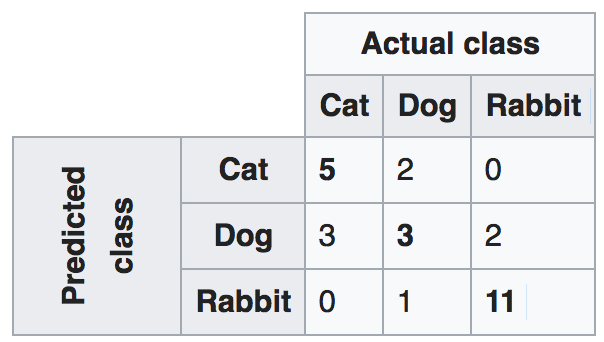

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

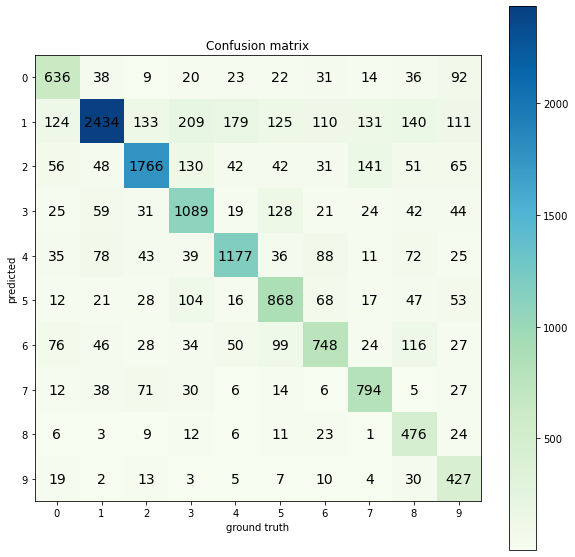

In [132]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    # TODO: Implement filling the prediction matrix
    for i in range(10):
        for j in range(10):
            confusion_matrix[i, j] = sum((predictions==i)&(ground_truth==j))
        
    
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

In [192]:
data_train_images = dset.SVHN("D:/DS/DL/dlcourse_ai/assignments/data", split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(np.asarray(sample)) 
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    indices = np.array(val_indices)[(predictions==predicted_class)&(gt==gt_class)]
    visualize_images(indices, data, title='Картинки класса %i, определенные как класс %i' % (gt_class, predicted_class), max_num=10)    
    

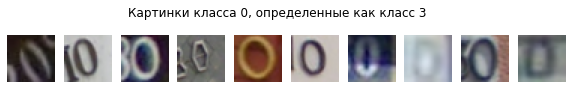

In [197]:
visualize_predicted_actual(3, 0, predictions, gt, val_indices, data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [ ]:
# Experiment here!

loss_history = [] # здесь история по гиперпараметрам, а не по эпохам !!! 
train_history = [] # здесь история по гиперпараметрам, а не по эпохам !!!
val_history = [] # здесь история по гиперпараметрам, а не по эпохам !!!
reg_strength_history = []
learning_rate_history = []

nmb_experiments = 10 # maxim>=100
for count in range(nmb_experiments):
    print('Count #: %f'% (count+1))
    reg_strength = 10**np.random.uniform(-6,0) 
    learning_rate = 10**np.random.uniform(-6,0)
    print('reg_strength: %f'% (reg_strength))
    print('learning_rate: %f'% (learning_rate))
        
    nn_model = nn.Sequential(Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),             
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),             
            nn.Linear(100, 10)
             )
    nn_model.type(torch.FloatTensor)
    optimizer = optim.SGD(nn_model.parameters(), lr=learning_rate, weight_decay=reg_strength)
    loss_, train_, val_ = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)
    loss_history.append(loss_[-1])
    train_history.append(train_[-1])
    val_history.append(val_[-1])
    reg_strength_history.append(reg_strength)
    learning_rate_history.append(learning_rate)

print('best validation accuracy achieved: %f at reg_strength %f and learning_rate  %f' % (np.max(val_history), reg_strength_history[np.argmax(val_history)], learning_rate_history[np.argmax(val_history)])   )





In [24]:
reg_strength_best = reg_strength_history[np.argmax(val_history)]
learning_rate_best = learning_rate_history[np.argmax(val_history)]
reg_strength_list =  np.array([0.8, 0.9, 1.0, 1.1, 1.2])*reg_strength_best
learning_rate_list = np.array([0.7, 1.0, 1.3])*learning_rate_best

loss_history = []
train_history = []
val_history = []
reg_strength_history = []
learning_rate_history = []



for reg_strength in reg_strength_list:
    for learning_rate in learning_rate_list:
        print('reg_strength: %f'% (reg_strength))
        print('learning_rate: %f'% (learning_rate))
        nn_model = nn.Sequential(Flattener(),
                nn.Linear(3*32*32, 100),

                nn.ReLU(inplace=True),
                nn.BatchNorm1d(100),             
                nn.Linear(100, 100),

                nn.ReLU(inplace=True),
                nn.BatchNorm1d(100),             
                nn.Linear(100, 10)
             )
        nn_model.type(torch.FloatTensor)

        optimizer = optim.SGD(nn_model.parameters(), lr=learning_rate, weight_decay=reg_strength)
        loss_, train_, val_ = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

        loss_history.append(loss_[-1])
        train_history.append(train_[-1])
        val_history.append(val_[-1])
        reg_strength_history.append(reg_strength)
        learning_rate_history.append(learning_rate)



print('best validation accuracy achieved: %f at reg_strength %f and learning_rate  %f' % (np.max(val_history), reg_strength_history[np.argmax(val_history)], learning_rate_history[np.argmax(val_history)])   )
    


reg_strength: 0.002160
learning_rate: 0.028000
Average loss: 1.346524, Train accuracy: 0.566921, Val accuracy: 0.672377
Average loss: 0.957139, Train accuracy: 0.700321, Val accuracy: 0.725206
Average loss: 0.833901, Train accuracy: 0.739088, Val accuracy: 0.762201
Average loss: 0.760382, Train accuracy: 0.762192, Val accuracy: 0.770869
Average loss: 0.712388, Train accuracy: 0.778129, Val accuracy: 0.782745
reg_strength: 0.002160
learning_rate: 0.040000
Average loss: 1.329683, Train accuracy: 0.572621, Val accuracy: 0.691762
Average loss: 0.955070, Train accuracy: 0.699382, Val accuracy: 0.723841
Average loss: 0.834643, Train accuracy: 0.740436, Val accuracy: 0.757354
Average loss: 0.765810, Train accuracy: 0.762243, Val accuracy: 0.753327
Average loss: 0.722601, Train accuracy: 0.775944, Val accuracy: 0.789639
reg_strength: 0.002160
learning_rate: 0.052000
Average loss: 1.321224, Train accuracy: 0.571529, Val accuracy: 0.660774
Average loss: 0.956670, Train accuracy: 0.701839, Val ac

In [30]:
# Как всегда, в конце проверяем на test set, здесь до обучения НА ВСЕМ ТРЕЙНЕ:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy) 

Test accuracy: 0.8044


In [42]:
# получаем веса модели с оптимальными гиперпараметрами НА ВСЕМ ТРЕЙНЕ (Val accuracy здесь не информативна)
indices = list(range(data_size))
np.random.shuffle(indices)

all_train_sampler = SubsetRandomSampler(indices)

all_train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=all_train_sampler)

lmbda = coef_lmbda_list[np.argmax(val_history)]
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
nn_model = nn.Sequential(Flattener(),
                    nn.Linear(3*32*32, 100),

                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(100),             
                    nn.Linear(100, 100),

                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(100),             
                    nn.Linear(100, 10)
                 )
nn_model.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=learning_rate_best, weight_decay=reg_strength_best)
loss_, train_, val_ = train_model(nn_model, all_train_loader, val_loader, loss, optimizer, 20)

        

Average loss: 1.271677, Train accuracy: 0.591534, Val accuracy: 0.712375
Average loss: 0.915587, Train accuracy: 0.715495, Val accuracy: 0.715583
Average loss: 0.802779, Train accuracy: 0.751764, Val accuracy: 0.752304
Average loss: 0.746330, Train accuracy: 0.767422, Val accuracy: 0.795031
Average loss: 0.696914, Train accuracy: 0.784703, Val accuracy: 0.816531
Average loss: 0.671075, Train accuracy: 0.791610, Val accuracy: 0.828066
Average loss: 0.651507, Train accuracy: 0.797357, Val accuracy: 0.795168
Average loss: 0.636960, Train accuracy: 0.802831, Val accuracy: 0.812095
Average loss: 0.622873, Train accuracy: 0.806722, Val accuracy: 0.810730
Average loss: 0.610466, Train accuracy: 0.809943, Val accuracy: 0.834141
Average loss: 0.608419, Train accuracy: 0.810612, Val accuracy: 0.837554
Average loss: 0.598122, Train accuracy: 0.815253, Val accuracy: 0.831206
Average loss: 0.588462, Train accuracy: 0.817779, Val accuracy: 0.811071
Average loss: 0.587409, Train accuracy: 0.818625, V

In [43]:
# Как всегда, в конце проверяем на test set. После обучения НА ВСЕМ ТРЕЙНЕ Test accuracy получилась почему то меньше! 
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy) 

Test accuracy: 0.7563
